![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# XAI for Transformers: Attention Maps for Images

In this tutorial, we will explore the process of generating attention maps for images using vision transformers.

-------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/xai-for-transformer/4-Tutorial_AttentionMaps_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [1]:
# Mount drive folder to dbe abale to download repo
# from google.colab import drive
# drive.mount('/content/drive')

# Switch to correct folder'
# %cd /content/drive/MyDrive

# Don't run this cell if you already cloned the repo 
# %rm -r XAI-Tutorials
# !git clone --branch main https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
# %cd XAI-Tutorials

### Imports

In [ ]:
import numpy as np
import torch 
import torch.nn as nn


import warnings
warnings.filterwarnings("ignore")

import sys  
sys.path.append('./')
import utils

sys.path.append('../models/')
from model_vit import VitGenerator

import matplotlib.pyplot as plt 
%matplotlib inline

We fix the random seeds to ensure reproducible results as we work with (pseudo) random numbers.

In [3]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

---

## Model Loading

We instantiate a Vision Transformer (VitGenerator) that we will use for the classification of the image that we just loaded. 

The class VitGenerator takes the following arguments:
- `name_model`, where we choose between three pre-trained transformer models: vit_tiny, vit_small, and vit_base. Here, we will use vit_small, which has 6 heads.
- `patch_size`, which is the size of each square patch. The image is divided into patches of this size.
- `device` which the computing device (CPU or GPU) to which tensors should be sent before performing operations.
- `evaluate` to specify that we want to use the model in eval mode, not training mode.
- `random` to specify that we do want a pre-trained model.
- `verbose` to print some info concerning the patch size and model loading.

Before we instatiate the model, we check the available device (either CPU or GPU).

In [4]:
name_model = 'vit_small'
patch_size = 8

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if device.type == "cuda":
    torch.cuda.set_device(1)

evaluate = True
random = False
verbose = True

In [5]:
model = VitGenerator(name_model, patch_size, device, evaluate=evaluate, random=random, verbose=verbose)

[INFO] Initializing vit_small with patch size of 8
[INFO] Loading weights


Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth" to /Users/lisasousa/.cache/torch/hub/checkpoints/dino_deitsmall8_300ep_pretrain.pth
100%|██████████| 82.7M/82.7M [00:02<00:00, 36.6MB/s]


## Attention Maps for Image Models

An attention map is a graphical representation that showcases where a model is 'looking'—or paying attention to—when it makes a prediction. These maps are visual aids that highlight the importance or relevance of different parts of the input data, such as text tokens or image patches.

**Please visit our [Introduction to Attention Maps](https://xai-tutorials.readthedocs.io/en/latest/_model_specific_xai/am.html#) to get more theoretical background information on how Attention Maps are calculated for different data modalities.**

***Note: we provide all references [here](https://xai-tutorials.readthedocs.io/en/latest/_model_specific_xai/am.html#references).***

### Calculation

We can generate our attention maps using the [DINO's code](https://github.com/facebookresearch/dino):

1. **Image Preprocessing**: We first ensure that the image's width and height are divisible by the patch size, trimming the image if necessary. This ensures that when we divide the image into patches, each patch is of a consistent size, with no leftover pixels.

2. **Feature Map Dimensions Calculation**: Once the image is resized, we compute the width and height of the feature map by dividing the image's dimensions by the patch size. This results in a grid of patches that the ViT will process.

3. **Attention Weights Retrieval**: We then retrieve the attention weights from the model for the given image, which is first sent to the specified device. These weights are part of the model's output and indicate the importance the model assigns to each patch when making a prediction.

4. **Attention Weights Reshaping for Visualization**: The attention tensor is typical of [batch_size, num_heads, num_patches, num_patches], where each entry indicates attention from one patch to another. We focus on how the class token is attending to the various patches of the image, which can be insightful for understanding what parts of the image the model finds most relevant for its task. 

5. **Upscaling Attention Maps**: Finally, the attention weights are upscaled to match the original image dimensions for a more intuitive visualization. This is achieved using nearest-neighbor interpolation, which avoids smoothing and preserves the original attention patterns. The upscaled attention maps are then converted from tensors to numpy arrays, preparing them for display alongside the original image to see where the model focuses its attention.


In [6]:
def get_attention_map(model, img_pre, patch_size, device):
    w, h = img_pre.shape[2] - img_pre.shape[2] % patch_size, img_pre.shape[3] - \
        img_pre.shape[3] % patch_size
    img_pre = img_pre[:, :, :w, :h]

    w_featmap = img_pre.shape[-2] // patch_size
    h_featmap = img_pre.shape[-1] // patch_size

    # Get the attention maps
    attentions = model.get_last_selfattention(img_pre.to(device))
    nh = attentions.shape[1]  # number of head

    # keep only the output patch attention
    attentions = attentions[0, :, 2, 1:].reshape(nh, -1)
    attentions = attentions.reshape(nh, w_featmap, h_featmap)

    # resize the attention map to the size of the resized input image
    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
    
    return attentions

### Visualization

The attention maps display varying 'heat' levels across different regions. These 'heat' levels are derived from the attention scores, with brighter areas suggesting higher relevance or influence on the model's output. In this way, attention maps provide an interpretable layer that reveals which parts of the input data are being given more weight by the model during prediction.

#### Example 1: Dog Image

We first load the image we want to analyze and convert it to an RGB channel.

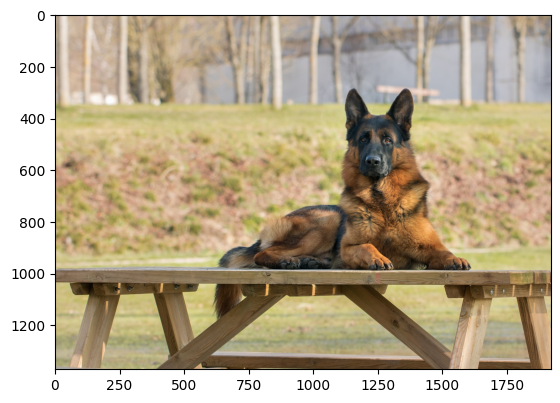

In [7]:
img = utils.read_image_cv('../data/images/dog.jpg')
plt.imshow(img)
plt.show()

We need to perform some transformations to the image (convert to PIL format, resize to a lower resolution, convert to tensor type, and normalize the pixel values) and unsqueeze the image to add a batch dimension.  
Because the image size is too big, we will reduce it by a factor of 2. Resizing the image here can be done for several reasons:
- If the image is too large, attention maps might be too detailed and harder to interpret. By reducing the size, attention patterns might become more evident, providing more precise insights into which parts of the image the model focuses on.
- Reducing the image size might ensure that patches cover meaningful parts of the image and do not introduce artifacts due to partial objects or features.
- Due to the initial linear projection, the fixed size of patches limits scalability. This limitation compels us to resize the image, aiming for improved interpretability within the given constraints.
- Larger images have more pixels, and processing them can be computationally expensive. Reducing the image size can make the processing faster.

In [8]:
print("Original Image size: ", img.shape)

Original Image size:  (1371, 1920, 3)


In [9]:
# define the transformations (here we are using the ImageNet transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

factor_reduce = 2
img_size = tuple(np.array(img.shape[:2]) // factor_reduce)

img_pre = utils.transform_img(img, mean, std, img_size=img_size)     

In [10]:
print('Transformed image size: ', img_pre.size())

Transformed image size:  torch.Size([1, 3, 685, 960])


Now we can compute the attention weights using the DINO's code from above.

In [11]:
attentions = get_attention_map(model, img_pre, patch_size, device)

We plot two figures; the first displays the original image and the mean of the 8 heads. The second displays the 6 attention weights of each head.

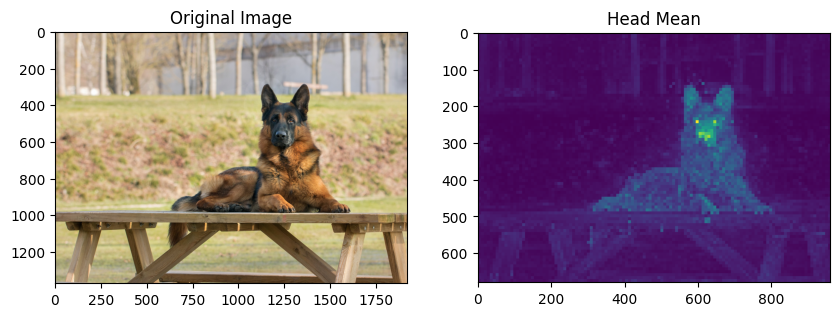

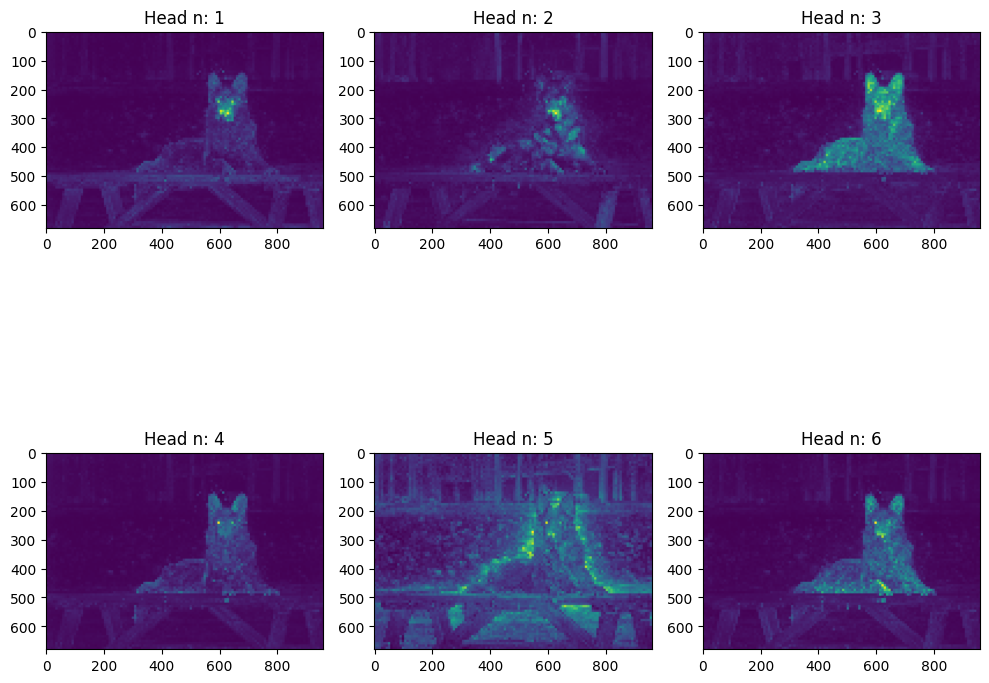

In [12]:
utils.plot_attention_maps(img, attentions)

The figures show a set of attention maps from a multi-headed model, each corresponding to a different 'head' of the attention mechanism, alongside the original image of a dog.
The "Head Mean" image is an aggregate of the attention across all heads, showing the overall areas of focus.

From the figures, we can observe that:
- Each map varies in focus, with some heads concentrating on the dog's face and others on different body parts or the surrounding context.
- The model consistently pays attention to the dog, especially its facial area, across several heads.
- Some heads are more focused on the background, suggesting an analysis of context.
- The combined 'Head Mean' map shows a clear concentration of attention on the central part of the dog, indicating its importance in the model's prediction process.


#### Example 2: Iguana Image

Now let's try a different example image of an iguana. Again, we first load the image and convert it to an RGB channel.

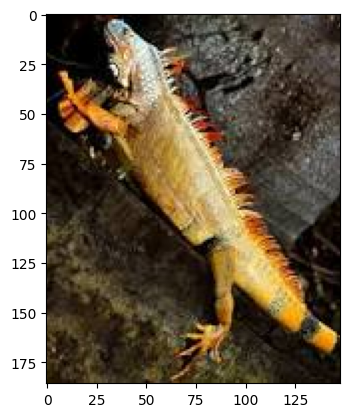

In [13]:
img = utils.read_image_cv('../data/images/Iguana.jpeg')
plt.imshow(img)
plt.show()

In [14]:
print("Image size: ", img.shape)

Image size:  (186, 148, 3)


Our iguana Image is not really big. So, we resize it to a larger size to have a better attention map.

In [15]:
# define the transformations (here we are using the ImageNet transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

img_size = (512, 512)
img_pre = utils.transform_img(img, mean, std, img_size=img_size)

In [16]:
print('Transformed image size: ', img_pre.size())

Transformed image size:  torch.Size([1, 3, 512, 512])


Now we can compute and plot the attention maps as for example 1.

In [17]:
attentions = get_attention_map(model, img_pre, patch_size, device)

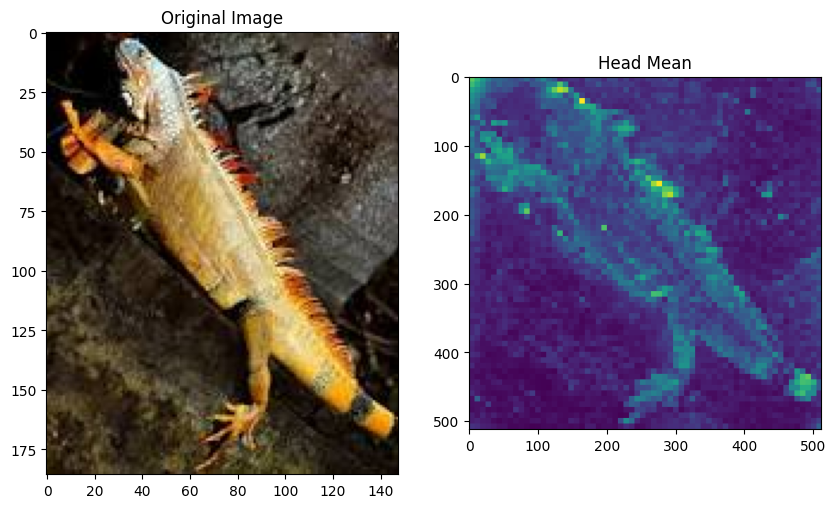

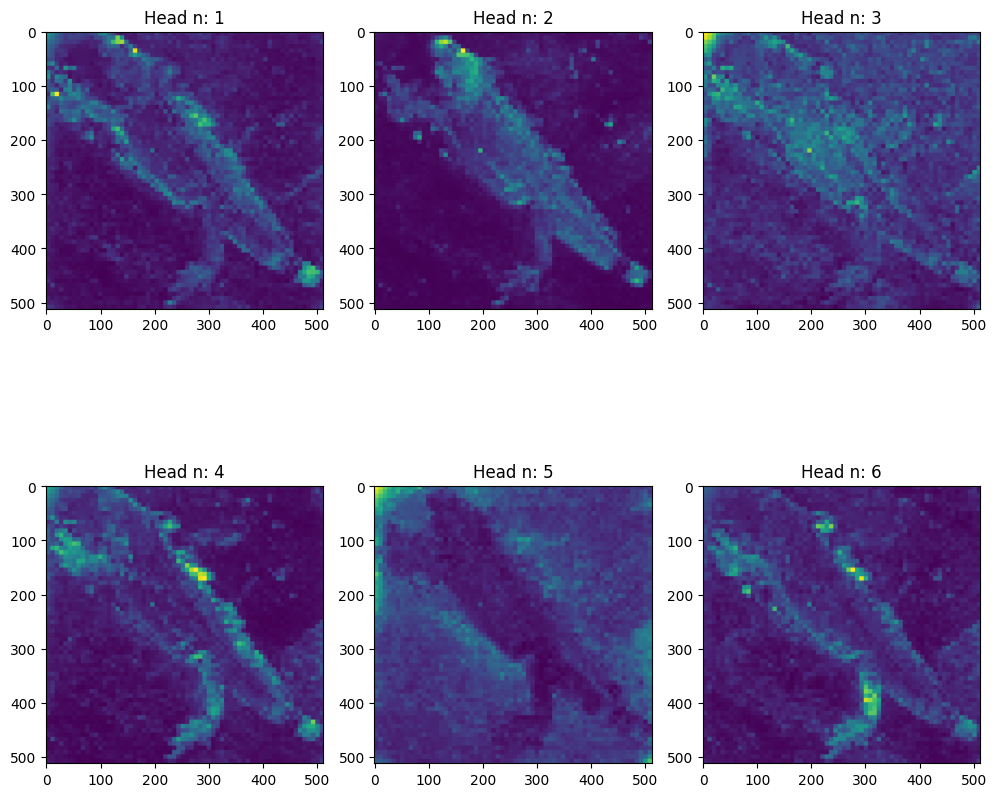

In [18]:
utils.plot_attention_maps(img, attentions)

The attention maps derived from the vision-based model for each head display distinct focal patterns on the image of an iguana. 
- Head 1 concentrates attention on the iguana's midsection, possibly isolating central characteristics vital to the model's interpretation. 
- Head 2 presents a linear focus along the iguana's body, suggesting an analysis of elongated features. 
- In contrast, Head 3 is attentive to both the head and the tail, areas that may be crucial for recognizing the creature's extremities. 
- Head 4's attention is pinpointed on a specific area, indicative of the model identifying a particular feature of importance. 
- Head 5 shows a diffused pattern of attention, hinting at a broader evaluation of the iguana or its environment. 
- Meanwhile, Head 6 intensively focuses on the tail, signaling the significance of this feature in the model’s processing. 
- Collectively, these maps illustrate how the model's different heads contribute to a holistic understanding by focusing on varied, yet complementary, features of the iguana, with the "Head Mean" providing an aggregated view of the areas deemed most informative.